Importing python packages and checking what files there are in the dataset

In [36]:
import numpy as np # mathematical operations on data
import pandas as pd # data manipulation and data processing
import seaborn as sns # Seaborn for visualization

Setting visualisation parameters

In [37]:
# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

# Set default font size and facecolor
plt.rcParams["font.size"] = 24
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize
figsize(15, 12)


Reading and exploring data

In [38]:
data = pd.read_csv("Video_Games_Sales.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
Name               16717 non-null object
Platform           16719 non-null object
Year_of_Release    16450 non-null float64
Genre              16717 non-null object
Publisher          16665 non-null object
NA_Sales           16719 non-null float64
EU_Sales           16719 non-null float64
JP_Sales           16719 non-null float64
Other_Sales        16719 non-null float64
Global_Sales       16719 non-null float64
Critic_Score       8137 non-null float64
Critic_Count       8137 non-null float64
User_Score         10015 non-null object
User_Count         7590 non-null float64
Developer          10096 non-null object
Rating             9950 non-null object
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


Here I am doing 3 things:
1. Renaming columns for ease of use
2. Droping games without a year of release or genre
3. Creating a new column for age of the game

In [39]:
data = data.rename(columns={"Year_of_Release": "Year", 
                            "NA_Sales": "NA",
                            "EU_Sales": "EU",
                            "JP_Sales": "JP",
                            "Other_Sales": "Other",
                            "Global_Sales": "Global"})
data = data[data["Year"].notnull()]
data = data[data["Genre"].notnull()]
data["Year"] = data["Year"].apply(int)
data["Age"] = 2018 - data["Year"]
data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Name,16448,11429,Need for Speed: Most Wanted,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Platform,16448,31,PS2,2127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,16448,NaN,NaN,NaN,2006.49,5.87747,1980,2003,2007,2010,2020
Genre,16448,12,Action,3308,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Publisher,16416,579,Electronic Arts,1344,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NA,16448,NaN,NaN,NaN,0.263965,0.818286,0,0,0.08,0.24,41.36
EU,16448,NaN,NaN,NaN,0.145895,0.50666,0,0,0.02,0.11,28.96
JP,16448,NaN,NaN,NaN,0.0784715,0.311064,0,0,0,0.04,10.22
Other,16448,NaN,NaN,NaN,0.0475833,0.187984,0,0,0.01,0.03,10.57
Global,16448,NaN,NaN,NaN,0.53617,1.55846,0.01,0.06,0.17,0.47,82.53


2 things to be checked
1. We'll search for NaN values
2. Outliers

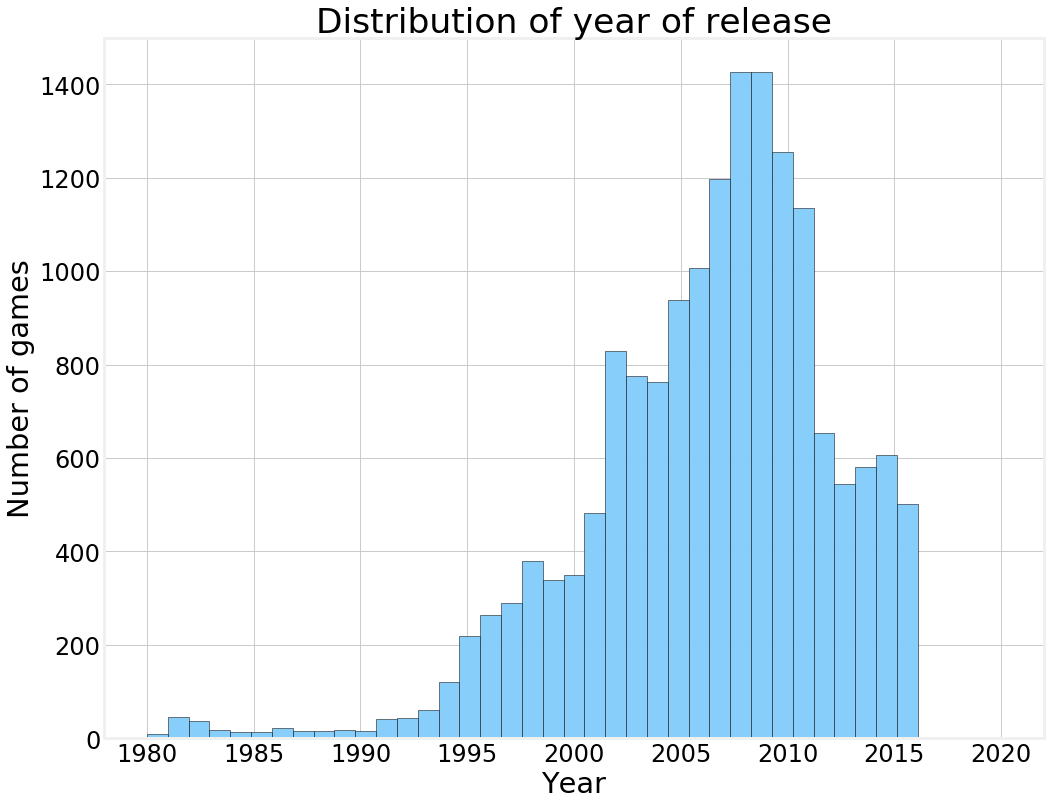

In [40]:
# Histogram plot of Year of release
num_years = data["Year"].max() - data["Year"].min() + 1
plt.hist(data["Year"], bins=num_years, color="lightskyblue", edgecolor="black")
plt.title("Distribution of year of release")
plt.xlabel("Year")
plt.ylabel("Number of games");

/home/admin1/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/admin1/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


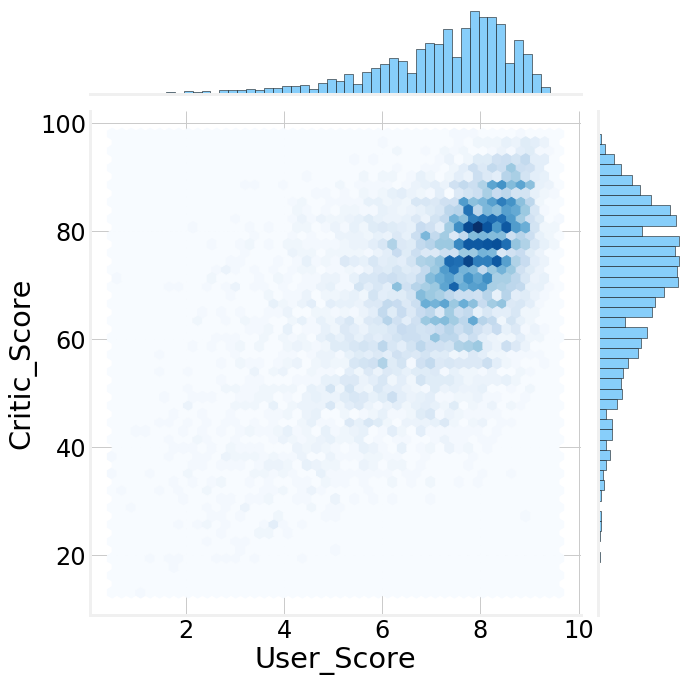

In [41]:
# Replacing "tbd" values with np.nan and transforming column to float type
data["User_Score"] = data["User_Score"].replace("tbd", np.nan).astype(float)

g = sns.jointplot(x="User_Score", y="Critic_Score", data=data, cmap="Blues", kind="hex", 
                  size=10, marginal_kws={"hist_kws" : {"edgecolor": "black", "color": "lightskyblue", "alpha": 1}}, 
                  annot_kws={"loc": 4, "fontsize": 18});
g.ax_marg_x.grid(False)
g.ax_marg_y.grid(False);

Most of the games have a pretty good score, 7+ (or 70+ for critic score). Pearson's correlation coefficient is 0.58 between critic and user scores. 

Next I want to see how many values there are missing in each column. I am using a function I found in one of [William Koehrsen](https://towardsdatascience.com/@williamkoehrsen) blogs on Medium.

In [42]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : "Missing Values", 1 : "% of Total Values"})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        "% of Total Values", ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [43]:
missing_values_table(data)

Your selected dataframe has 17 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
User_Score,8985,54.6
User_Count,8985,54.6
Critic_Score,8465,51.5
Critic_Count,8465,51.5
Rating,6679,40.6
Developer,6541,39.8
Publisher,32,0.2


In [44]:
def rm_outliers(df, list_of_keys):
    df_out = df
    for key in list_of_keys:
        # Calculate first and third quartile
        first_quartile = df_out[key].describe()["25%"]
        third_quartile = df_out[key].describe()["75%"]

        # Interquartile range
        iqr = third_quartile - first_quartile

        # Remove outliers
        removed = df_out[(df_out[key] <= (first_quartile - 3 * iqr)) |
                    (df_out[key] >= (third_quartile + 3 * iqr))] 
        df_out = df_out[(df_out[key] > (first_quartile - 3 * iqr)) &
                    (df_out[key] < (third_quartile + 3 * iqr))]
    return df_out, removed

In [45]:
data, rmvd_global = rm_outliers(data, ["Global"])
data.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Age
count,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,15401.000000,7286.000000,7286.000000,6747.000000,6747.000000,15401.000000
mean,2006.592624,0.144688,0.072628,0.047301,0.024357,0.289258,67.779028,24.518117,7.079976,111.325033,11.407376
std,5.758078,0.210709,0.131408,0.130786,0.050152,0.346918,13.612120,17.194878,1.511031,406.635191,5.758078
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000,-2.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,59.000000,11.000000,6.300000,9.000000,8.000000
50%,2007.000000,0.070000,0.020000,0.000000,0.010000,0.150000,70.000000,20.000000,7.400000,21.000000,11.000000
75%,2010.000000,0.190000,0.080000,0.030000,0.030000,0.380000,78.000000,34.000000,8.200000,61.000000,15.000000
max,2020.000000,1.670000,1.580000,1.650000,1.180000,1.690000,98.000000,106.000000,9.700000,10665.000000,38.000000


 We'll try 2 ways here.
 First we'll make a simple model. 
 Then a complicated one.


In [46]:
data["Has_Score"] = data["User_Score"].notnull() & data["Critic_Score"].notnull()
rmvd_global["Has_Score"] = rmvd_global["User_Score"].notnull() & rmvd_global["Critic_Score"].notnull()

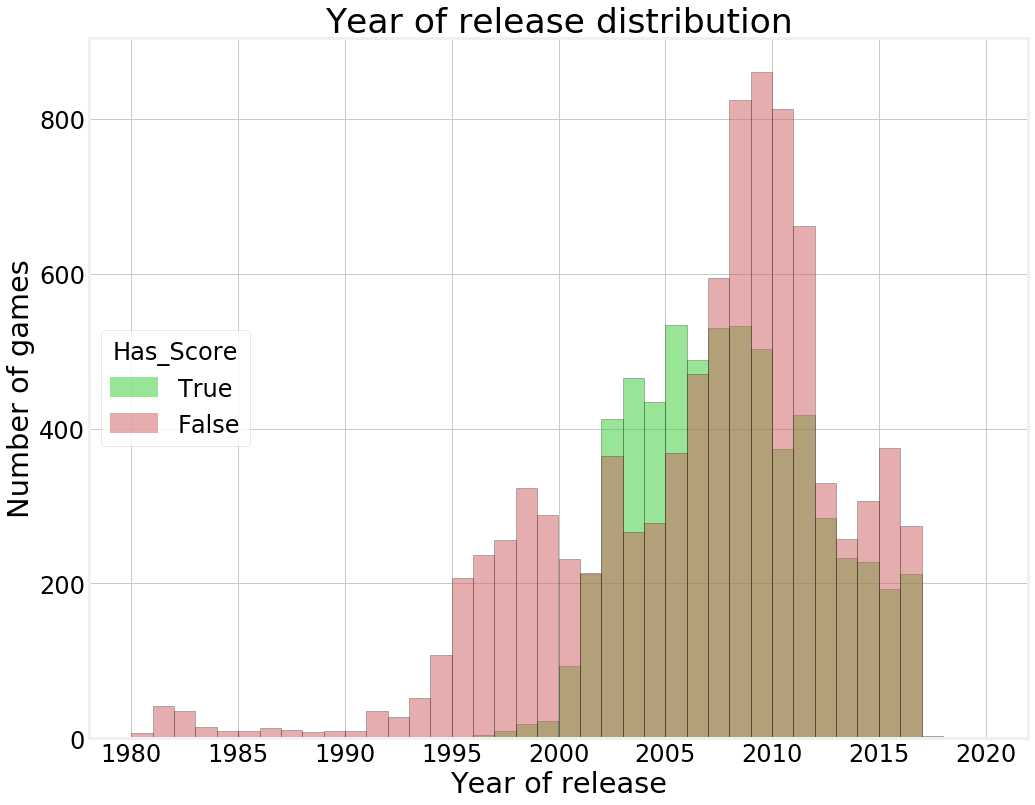

In [47]:
from matplotlib.lines import Line2D
plt.hist(data[data["Has_Score"]==True]["Year"], color="limegreen", alpha=0.5, 
         bins=range(1980, 2021), edgecolor="black")
plt.hist(data[data["Has_Score"]==False]["Year"], color="indianred", alpha=0.5, 
         bins=range(1980, 2021), edgecolor="black")
plt.title("Year of release distribution")
plt.xlabel("Year of release")
plt.ylabel("Number of games")
plt.legend(handles=[Line2D([0], [0], color="limegreen", lw=20, label="True", alpha=0.5),
                    Line2D([0], [0], color="indianred", lw=20, label="False", alpha=0.5)],
           title="Has_Score", loc=6);

We can see that games with score are more evenly spread between 2000 and 2015, while there is a peak at 2010 for games without score. 
Another difference we see is that in a range 1995-2000. Very few games from that period have scores, while the total number of games is quite significant. aI think videogames were only starting to rise in popularity, but there was no dedicated platform (like Steam now) or specialised magazine to review games.

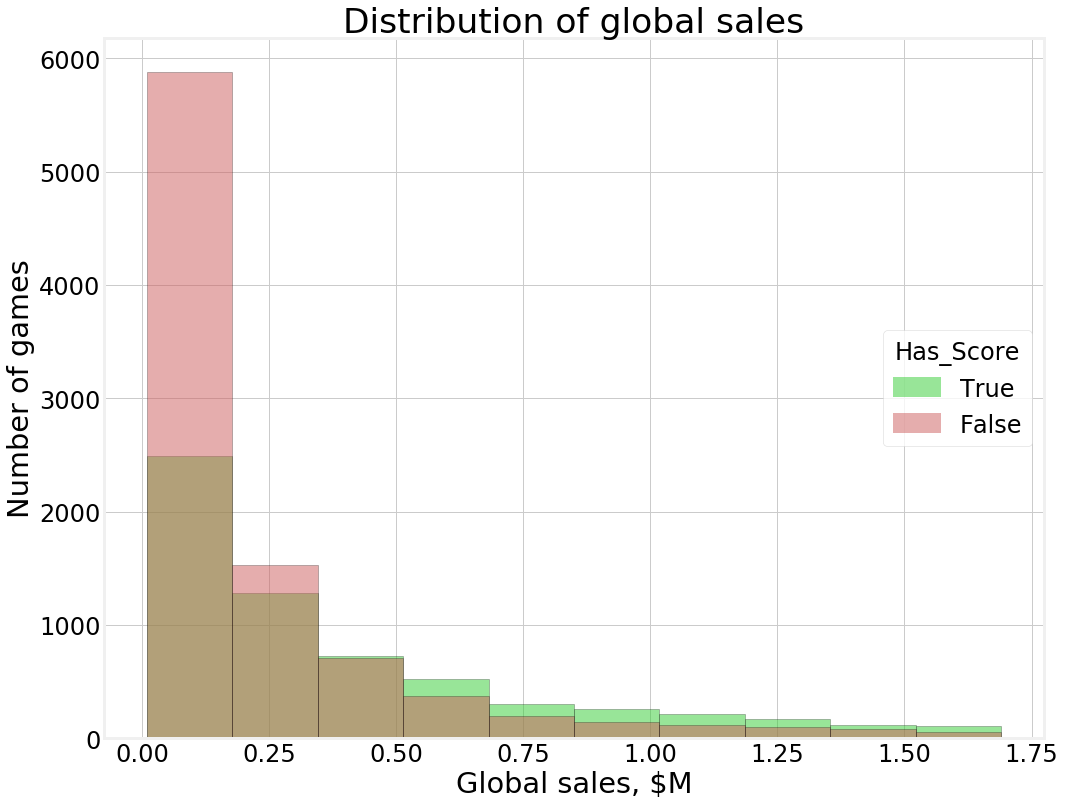

In [48]:
plt.hist(data[data["Has_Score"]==True]["Global"], color="limegreen", alpha=0.5, 
         edgecolor="black")
plt.hist(data[data["Has_Score"]==False]["Global"], color="indianred", alpha=0.5, 
         edgecolor="black")
plt.title("Distribution of global sales")
plt.xlabel("Global sales, $M")
plt.ylabel("Number of games")
plt.legend(handles=[Line2D([0], [0], color="limegreen", lw=20, label="True", alpha=0.5),
                    Line2D([0], [0], color="indianred", lw=20, label="False", alpha=0.5)],
           title="Has_Score", loc=7);

Games without score tend to have less global sales.

/home/admin1/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/admin1/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/admin1/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/admin1/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramt

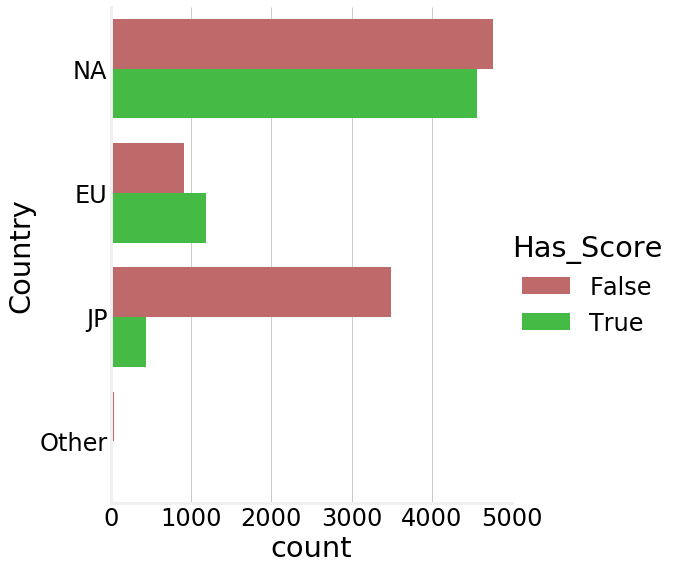

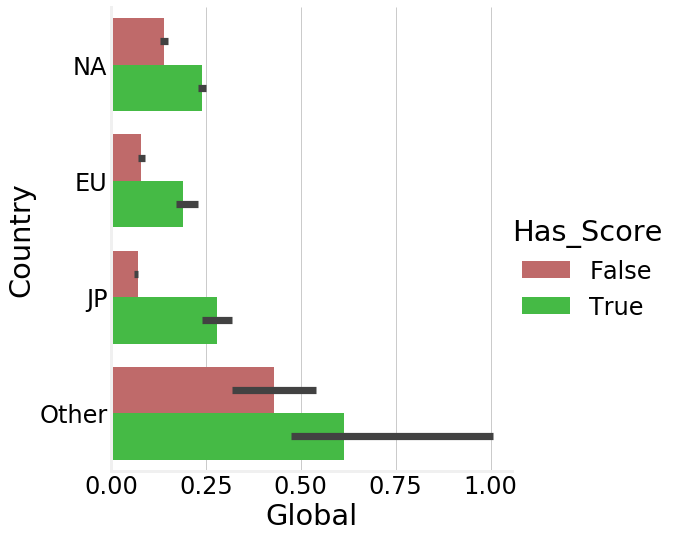

In [49]:
data["Country"] = data[["NA", "EU", "JP", "Other"]].idxmax(1, skipna=True)
palette = {True: "limegreen", False: "indianred"}
sns.factorplot(y="Country", hue="Has_Score", data=data, size=8, kind="count", palette=palette)
sns.factorplot(y="Country", x="Global", hue="Has_Score", data=data, size=8, kind="bar", palette=palette,
               estimator=lambda x: np.median(x));

While EU and NA have approximately the same number of scored and not scored games, situation is absolutely different for Japan. Majority of games, that were more popular in Japan than in other regions, does not have a user or critic score. Mean global sales is less for games without score, which confirmes what we saw from the histogram above.

## Basic model

For my basic model we're dropping games that don't have a user score, critic score or rating. 

In [50]:
scored = data.dropna(subset=["User_Score", "Critic_Score", "Rating"])
scored.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Age
count,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000,6137.000000
mean,2007.422682,0.209774,0.112472,0.029221,0.039420,0.391119,68.976047,26.910706,7.139661,118.897181,10.577318
std,4.171197,0.231764,0.154954,0.094207,0.059871,0.389871,13.627623,17.416288,1.450253,424.446207,4.171197
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.500000,4.000000,2.000000
25%,2004.000000,0.050000,0.010000,0.000000,0.010000,0.100000,61.000000,13.000000,6.400000,10.000000,8.000000
50%,2007.000000,0.130000,0.050000,0.000000,0.020000,0.240000,71.000000,23.000000,7.500000,23.000000,11.000000
75%,2010.000000,0.290000,0.150000,0.000000,0.050000,0.560000,79.000000,37.000000,8.200000,66.000000,14.000000
max,2016.000000,1.670000,1.580000,1.390000,1.180000,1.690000,98.000000,106.000000,9.600000,10665.000000,33.000000


Removing outliers in User_Count column.

In [51]:
scored, rmvd_user_count = rm_outliers(scored, ["User_Count"])
scored.describe()

,Year,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Age
count,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000
mean,2007.055837,0.205403,0.098572,0.028995,0.036368,0.369597,67.815866,24.958439,7.124575,37.459523,10.944163
std,4.010373,0.225580,0.138941,0.095492,0.056428,0.367824,13.408831,15.689528,1.440391,44.572477,4.010373
min,1985.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.500000,4.000000,2.000000
25%,2004.000000,0.060000,0.010000,0.000000,0.010000,0.100000,60.000000,13.000000,6.400000,9.000000,8.000000
50%,2007.000000,0.130000,0.040000,0.000000,0.020000,0.230000,70.000000,22.000000,7.400000,20.000000,11.000000
75%,2010.000000,0.280000,0.130000,0.000000,0.047500,0.520000,78.000000,34.000000,8.200000,45.000000,14.000000
max,2016.000000,1.670000,1.160000,1.390000,1.130000,1.690000,98.000000,91.000000,9.600000,233.000000,33.000000


 That doesn't seem good to me, but for a basic model it will be ok.

In [52]:
scored["Platform"].unique(), scored["Genre"].unique(), scored["Rating"].unique()

(array(['PS2', 'GBA', 'X360', 'PS3', 'PC', 'Wii', 'PSP', 'PS', 'XB', 'GC',
        'DS', 'XOne', '3DS', 'DC', 'PS4', 'WiiU', 'PSV'], dtype=object),
 array(['Shooter', 'Action', 'Role-Playing', 'Racing', 'Simulation',
        'Sports', 'Fighting', 'Platform', 'Misc', 'Strategy', 'Puzzle',
        'Adventure'], dtype=object),
 array(['M', 'E', 'T', 'E10+', 'RP'], dtype=object))

As we see there are 17 unique platfoms, 12 unique genres and 5 ratings in the remaining data. In the advanced model I will try grouping platforms to reduce amount, but for now I will just one-hot encode them. 

Feaures will consist of numeric columns (except for sales in regions and year - using age instead) and one-hot encoded categorical columns (platform, genre, rating).

In [53]:
import category_encoders as ce
# Select the numeric columns
numeric_subset = scored.select_dtypes("number").drop(columns=["NA", "EU", "JP", "Other", "Year"])

# Select the categorical column
categorical_subset = scored[["Platform", "Genre", "Rating"]]

# One hot encode
encoder = ce.one_hot.OneHotEncoder()
categorical_subset = encoder.fit_transform(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Find correlations with the score 
correlations = features.corr()["Global"].dropna().sort_values()

Let's look at the highest and lowest correlations with the global sales column. 

In [54]:
correlations.head(5)

Platform_5    -0.186725
Genre_10      -0.094686
Genre_12      -0.084227
Platform_17   -0.069683
Platform_15   -0.062370
Name: Global, dtype: float64

In [55]:
correlations.tail(5)

User_Score      0.155470
User_Count      0.252651
Critic_Score    0.281545
Critic_Count    0.292327
Global          1.000000
Name: Global, dtype: float64

Lowest correlation is Platform_PC, which seems strange to me. Highest are critic and user scores and counts, which is understandable. 

This is another usefull function I copied from William. It shows scatterplots, histograms and kdeplots of selected columns on a seaborn PairGrid.

/home/admin1/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))
/home/admin1/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


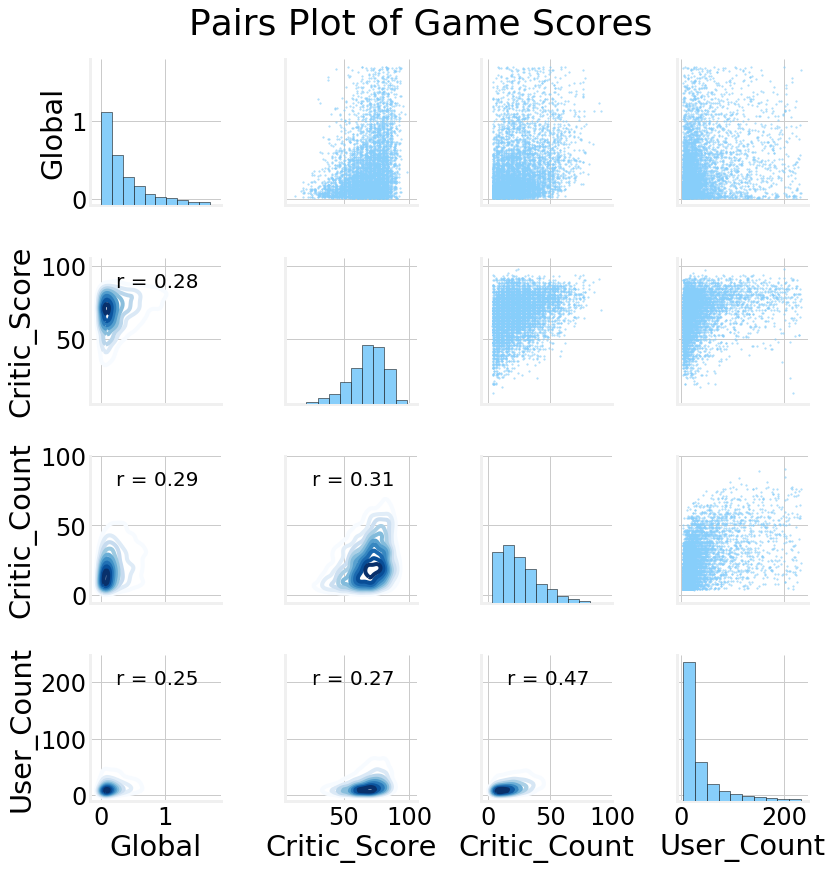

In [56]:
# Extract the columns to  plot
plot_data = features[["Global", "Critic_Score",
                      "Critic_Count", "User_Count"]]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)
    
# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, size = 3)

# Upper is a scatter plot
grid.map_upper(plt.scatter, color = "lightskyblue", alpha = 0.6, marker=".", s=10)

# Diagonal is a histogram
grid.map_diag(plt.hist, color = "lightskyblue", edgecolor="black")

# Bottom is correlation and density plot
grid.map_lower(corr_func)
grid.map_lower(sns.kdeplot, cmap = plt.cm.Blues)

# Title for entire plot
plt.suptitle("Pairs Plot of Game Scores", size = 36, y = 1.02);

In [57]:
features.shape

(5534, 43)

There are 39 features (1 is target) in the dataset after feature engineering and selection.

Splitting data into train and test sets.

In [58]:
from sklearn.model_selection import train_test_split
basic_target = pd.Series(features["Global"])
basic_features = features.drop(columns="Global")
features_train, features_test, target_train, target_test = train_test_split(basic_features, basic_target, 
                                                                            test_size=0.2,
                                                                            random_state=42)
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(4427, 42)
(1107, 42)
(4427,)
(1107,)


Defining a function to evaluate my model. I will use mean absolute error. 

In [59]:
def mae(y_true, y_pred):
    return np.average(abs(y_true - y_pred))

For the baseline guess I'll use median value of global sales in the train dataset.

In [60]:
baseline_guess = np.median(target_train)
basic_baseline_mae = mae(target_test, baseline_guess)
print("Baseline guess for global sales is: {:.02f}".format(baseline_guess))
print("Baseline Performance on the test set: MAE = {:.04f}".format(basic_baseline_mae))

Baseline guess for global sales is: 0.23
Baseline Performance on the test set: MAE = 0.2787


I will compare several simple models with different types of regression, and then focus on the best one for hyperparameter tuning. 

In [61]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

/home/admin1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


This is a universal function for training a model and evaluating its performance on test data.

In [62]:
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(features_train, target_train)
    
    # Make predictions and evalute
    model_pred = model.predict(features_test)
    model_mae = mae(target_test, model_pred)
    
    # Return the performance metric
    return model_mae

In [63]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print("Linear Regression Performance on the test set: MAE = {:.04f}".format(lr_mae))

Linear Regression Performance on the test set: MAE = 0.2361


In [64]:
svm = SVR(C = 1000, gamma=0.1)
svm_mae = fit_and_evaluate(svm)

print("Support Vector Machine Regression Performance on the test set: MAE = {:.04f}".format(svm_mae))

Support Vector Machine Regression Performance on the test set: MAE = 0.2859


In [65]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print("Random Forest Regression Performance on the test set: MAE = {:.04f}".format(random_forest_mae))

Random Forest Regression Performance on the test set: MAE = 0.2321


In [66]:
gradient_boosting = GradientBoostingRegressor(random_state=60)
gradient_boosting_mae = fit_and_evaluate(gradient_boosting)

print("Gradient Boosting Regression Performance on the test set: MAE = {:.04f}".format(gradient_boosting_mae))

Gradient Boosting Regression Performance on the test set: MAE = 0.2197


In [67]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print("K-Nearest Neighbors Regression Performance on the test set: MAE = {:.04f}".format(knn_mae))

K-Nearest Neighbors Regression Performance on the test set: MAE = 0.2556


In [68]:
ridge = Ridge(alpha=10)
ridge_mae = fit_and_evaluate(ridge)

print("Ridge Regression Performance on the test set: MAE = {:.04f}".format(ridge_mae))

Ridge Regression Performance on the test set: MAE = 0.2354


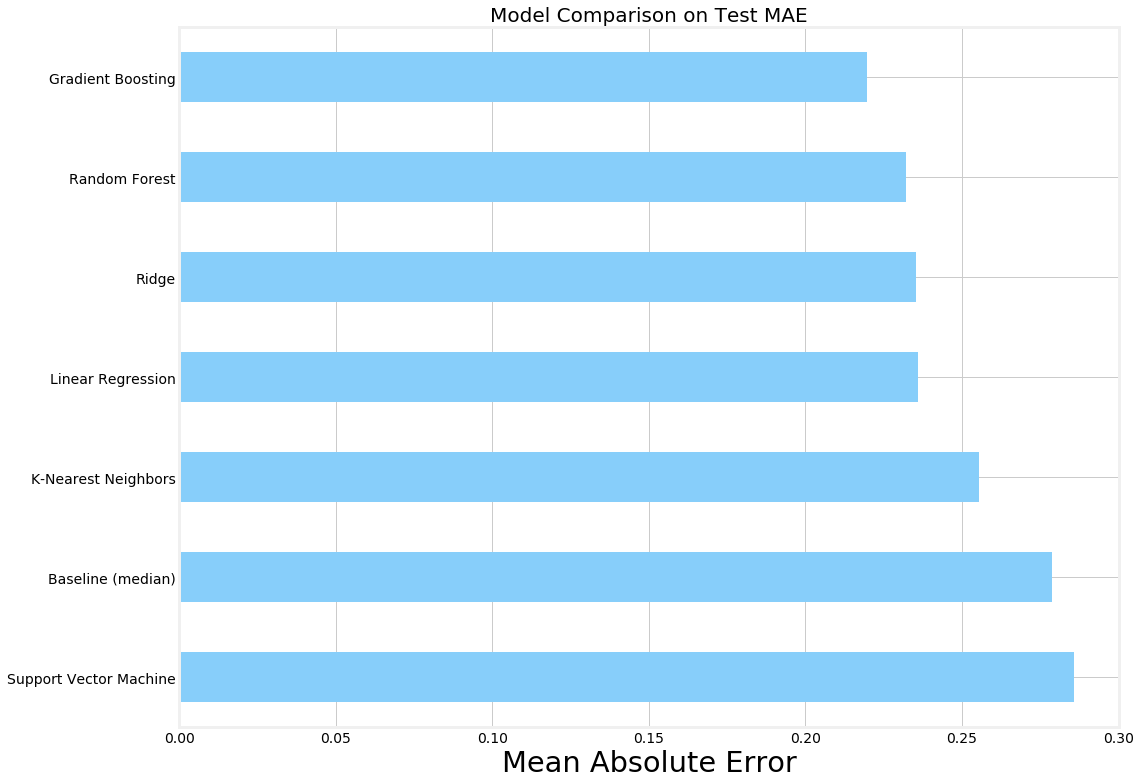

In [69]:
model_comparison = pd.DataFrame({"model": ["Linear Regression", "Support Vector Machine",
                                           "Random Forest", "Gradient Boosting",
                                            "K-Nearest Neighbors", "Baseline (median)", "Ridge"],
                                 "mae": [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosting_mae, knn_mae, basic_baseline_mae, ridge_mae]})
model_comparison.sort_values("mae", ascending=False).plot(x="model", y="mae", kind="barh",
                                                           color="lightskyblue", legend=False)
plt.ylabel(""); plt.yticks(size=14); plt.xlabel("Mean Absolute Error"); plt.xticks(size=14)
plt.title("Model Comparison on Test MAE", size=20);

Gradient boosting regressor seems to be the best model, I will focus on this one.  
  
  First I am going to use randomized search to find the best parameters, and then I will use grid search for optimizing n_estimators. 

In [70]:
# Loss function to be optimized
loss = ["ls", "lad", "huber"]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ["auto", "sqrt", "log2", None]

hyperparameter_grid = {"loss": loss,
                       "max_depth": max_depth,
                       "min_samples_leaf": min_samples_leaf,
                       "min_samples_split": min_samples_split,
                       "max_features": max_features}

In [71]:
from sklearn.model_selection import RandomizedSearchCV
basic_model = GradientBoostingRegressor(random_state = 42)

random_cv = RandomizedSearchCV(estimator=basic_model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=20, 
                               scoring="neg_mean_absolute_error",
                               n_jobs=-1, verbose=1, 
                               return_train_score=True,
                               random_state=42)

In [72]:
random_cv.fit(features_train, target_train)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   34.1s finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'loss': ['ls', 'lad', 'huber'], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'min_samples_split': [2, 4, 6, 10], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring='neg_mean_absolute_error',
          verbose=1)

Printing out 10 best estimators found by randomized search.

In [73]:
random_results = pd.DataFrame(random_cv.cv_results_).sort_values("mean_test_score", ascending=False)
random_results.head(10)[["mean_test_score", "param_loss",
                         "param_max_depth", "param_min_samples_leaf", "param_min_samples_split",
                         "param_max_features"]]

,mean_test_score,param_loss,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_max_features
0,-0.200241,huber,15,8,6,log2
17,-0.200558,lad,15,2,4,log2
7,-0.202401,huber,5,6,6,auto
16,-0.208902,lad,3,1,10,log2
15,-0.208952,ls,5,4,6,auto
8,-0.210779,lad,2,4,10,auto
19,-0.214095,lad,2,1,10,sqrt
3,-0.214285,lad,2,8,10,sqrt
1,-0.214556,huber,2,2,4,None
2,-0.217556,ls,3,1,4,sqrt


In [74]:
random_cv.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=15,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=8, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=42, subsample=1.0, verbose=0,
             warm_start=False)

Using grid search to find optimal value of the n_estimators parameter.

In [75]:
from sklearn.model_selection import GridSearchCV
trees_grid = {"n_estimators": [50, 100, 150, 200, 250, 300]}

basic_model = random_cv.best_estimator_
grid_search = GridSearchCV(estimator=basic_model, param_grid=trees_grid, cv=4, 
                           scoring="neg_mean_absolute_error", verbose=1,
                           n_jobs=-1, return_train_score=True)

In [76]:
grid_search.fit(features_train, target_train);

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   17.4s finished


Now I want to see how the number of trees effects the performance. 

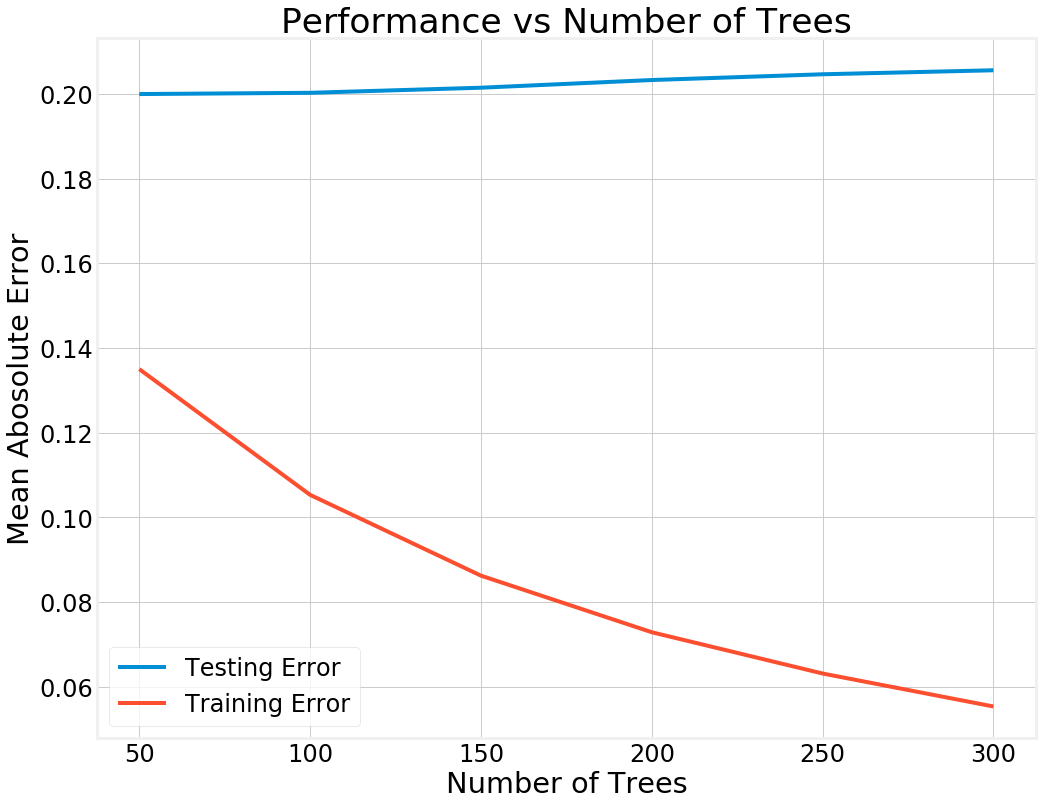

In [77]:
results = pd.DataFrame(grid_search.cv_results_)

plt.plot(results["param_n_estimators"], -1 * results["mean_test_score"], label = "Testing Error")
plt.plot(results["param_n_estimators"], -1 * results["mean_train_score"], label = "Training Error")
plt.xlabel("Number of Trees"); plt.ylabel("Mean Abosolute Error"); plt.legend();
plt.title("Performance vs Number of Trees");

The graph shows that the model is overfitting. Training error keeps decreasing, while test error stays almost the same. It means that the model learns training examples very well, but cannot generalize on new, unknown data. This is not a very good model, but I will leave it as is, and try to battle overfitting in the advanced model using imputing, feature selection and feature engineering.

Let's lock the final model and see how it performs on test data.

In [78]:
basic_final_model = grid_search.best_estimator_
basic_final_model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=15,
             max_features='log2', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=8, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=50, presort='auto',
             random_state=42, subsample=1.0, verbose=0, warm_start=False)

In [79]:
basic_final_pred = basic_final_model.predict(features_test)
basic_final_mae = mae(target_test, basic_final_pred)
print("Final model performance on the test set: MAE = {:.04f}.".format(basic_final_mae))

Final model performance on the test set: MAE = 0.2095.


MAE dropped, but by a very small margin. Looks like hyperparameter tuning didn't really improve the model. I hope advanced model will have a better performance.

To finish with the basic model I am going to draw 2 graphs. First one is comparison of densities of train values, test values and predictions.

/home/admin1/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


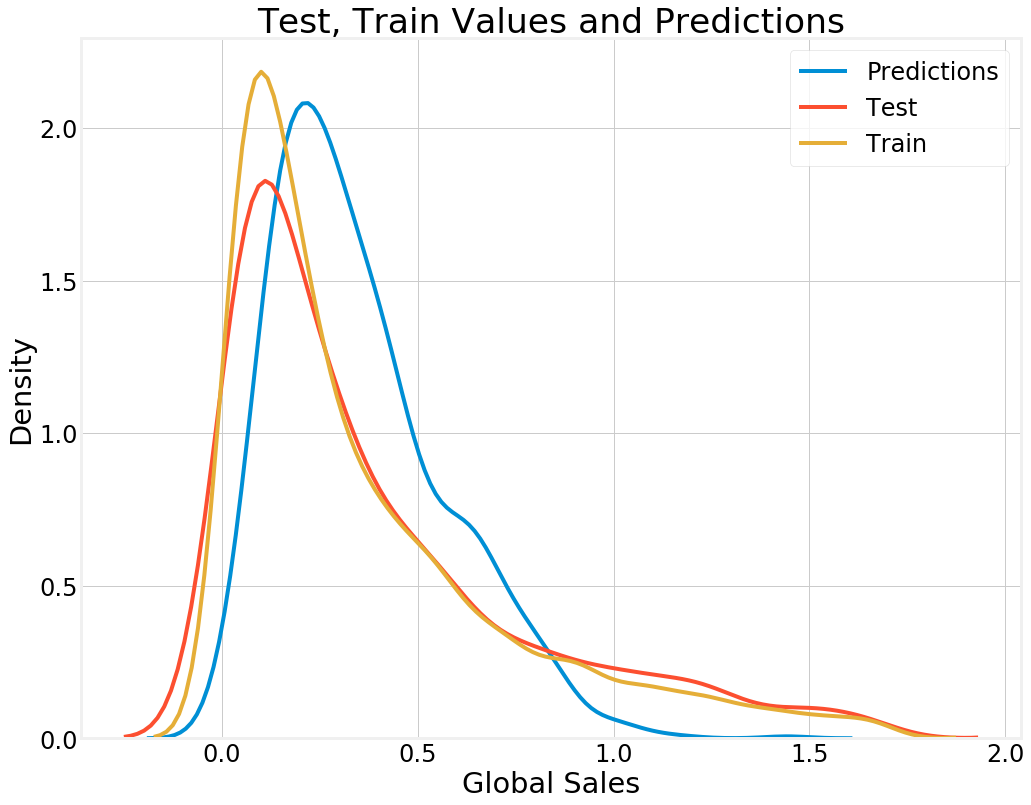

In [80]:
sns.kdeplot(basic_final_pred, label = "Predictions")
sns.kdeplot(target_test, label = "Test")
sns.kdeplot(target_train, label = "Train")

plt.xlabel("Global Sales"); plt.ylabel("Density");
plt.title("Test, Train Values and Predictions");

Predictions density is moved a little to the right, comparing to densities of initial values. The tail is also different. This might help tuning the model in the future. 

Second graph is a histogram of residuals - differences between real values and predictions. 

/home/admin1/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


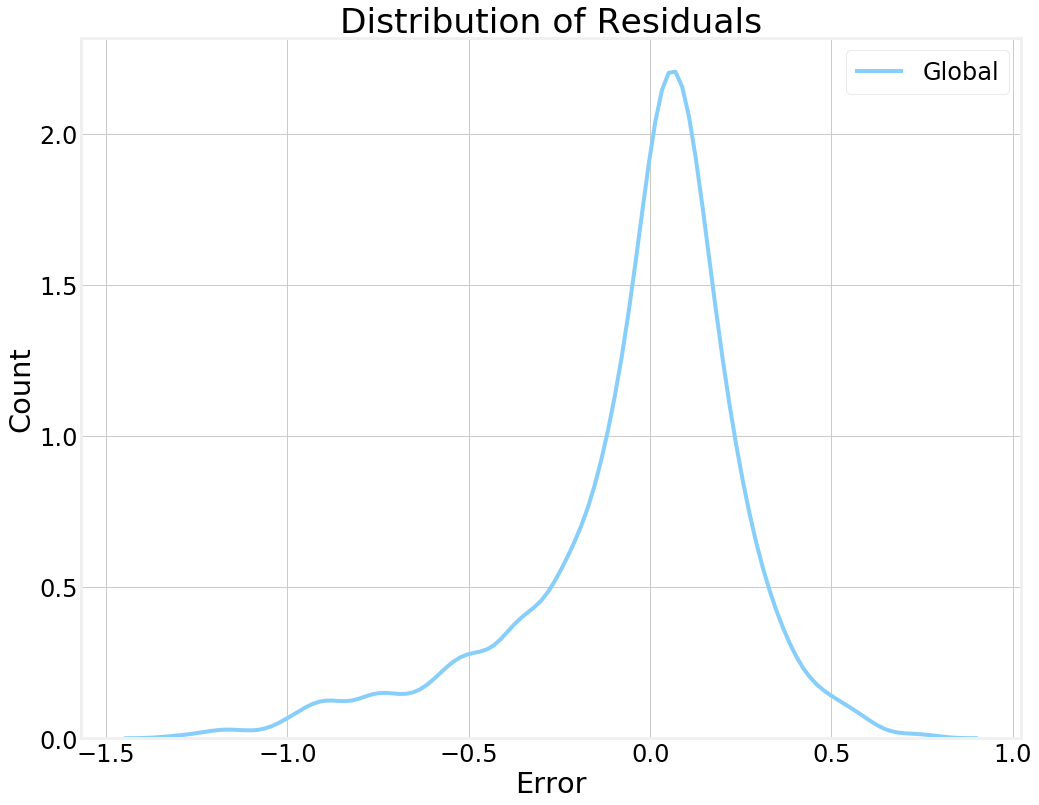

In [81]:
basic_residuals = basic_final_pred - target_test

sns.kdeplot(basic_residuals, color = "lightskyblue")
plt.xlabel("Error"); plt.ylabel("Count")
plt.title("Distribution of Residuals");

## Advanced model

In [82]:
def donut_chart(column, palette="Set2"):
    values = column.value_counts().values
    labels = column.value_counts().index
    plt.pie(values, colors=sns.color_palette(palette), 
            labels=labels, autopct="%1.1f%%", 
            startangle=90, pctdistance=0.85)
    #draw circle
    centre_circle = plt.Circle((0,0), 0.70, fc="white")
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

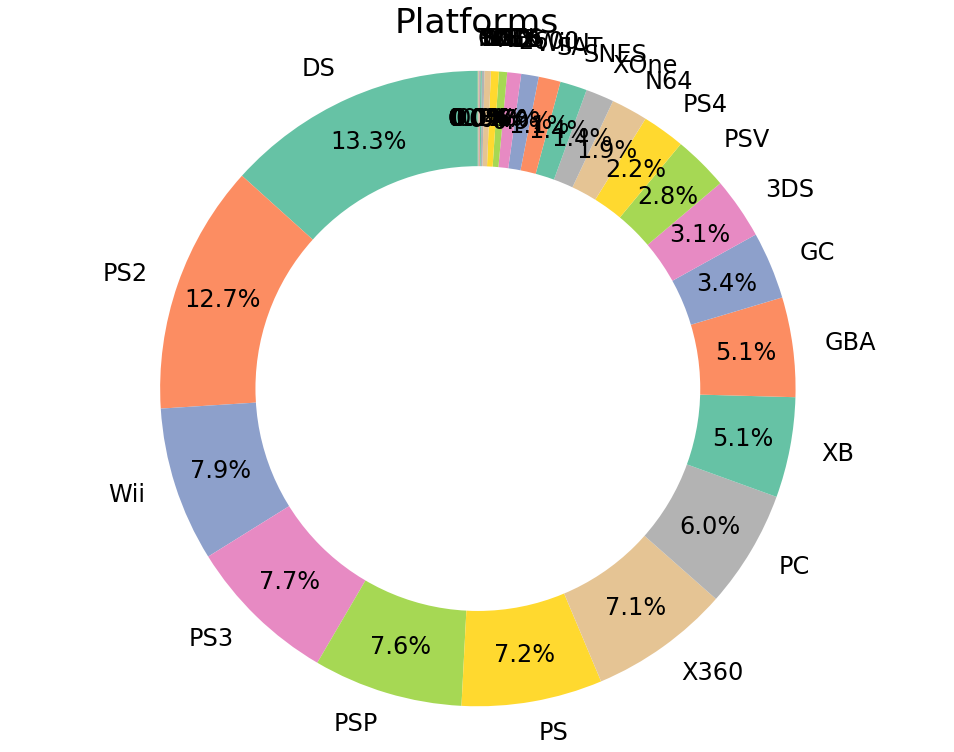

In [83]:
donut_chart(data["Platform"])
plt.title("Platforms")
plt.axis("equal");

In [84]:
data["Platform"].unique()

array(['Wii', 'PS2', 'PS3', 'PS', 'N64', 'GBA', 'DS', 'GC', 'X360', 'GB',
       'PC', '3DS', 'PSP', 'XB', 'NES', 'PS4', 'GEN', '2600', 'SNES',
       'XOne', 'WiiU', 'PSV', 'SCD', 'DC', 'SAT', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

There are too many different platforms and most of them represent a very small percent of games. I am going to group platforms to reduce the number of features.

In [85]:
platforms = {"Playstation" : ["PS", "PS2", "PS3", "PS4"],
             "Xbox" : ["XB", "X360", "XOne"], 
             "PC" : ["PC"],
             "Nintendo" : ["Wii", "WiiU"],
             "Portable" : ["GB", "GBA", "GC", "DS", "3DS", "PSP", "PSV"]}

In [86]:
def get_group_label(x, groups=None):
    if groups is None:
        return "Other"
    else:
        for key, val in groups.items():
            if x in val:
                return key
        return "Other"

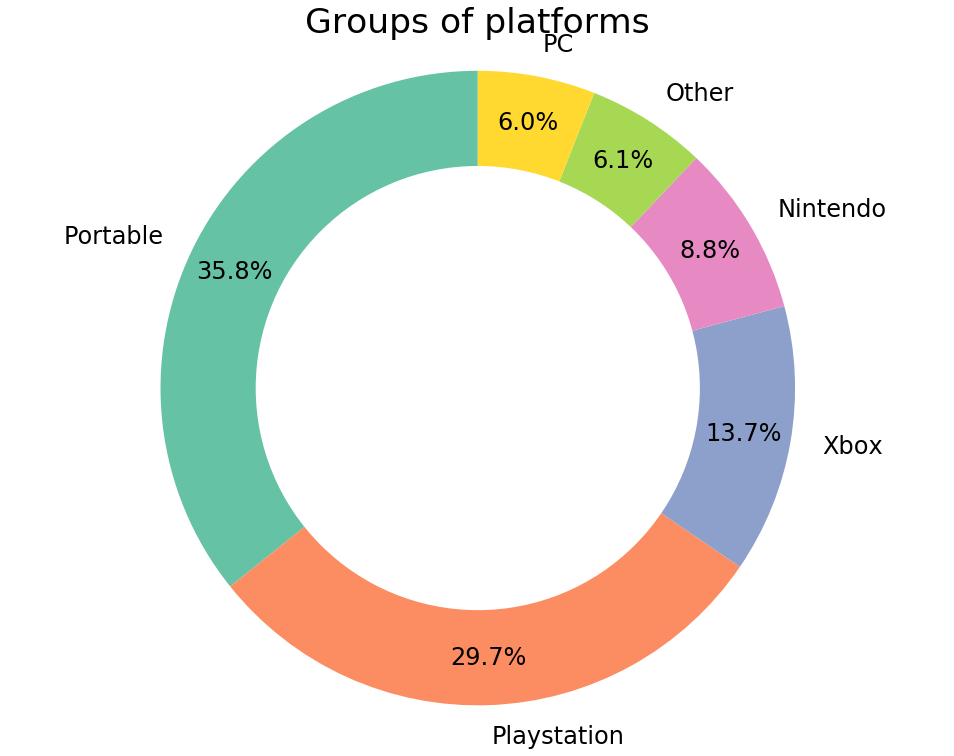

In [87]:
data["Grouped_Platform"] = data["Platform"].apply(lambda x: get_group_label(x, groups=platforms))
donut_chart(data["Grouped_Platform"])
plt.title("Groups of platforms")
plt.axis("equal");

Looks much better.

Now I want to check the same thing for genres.

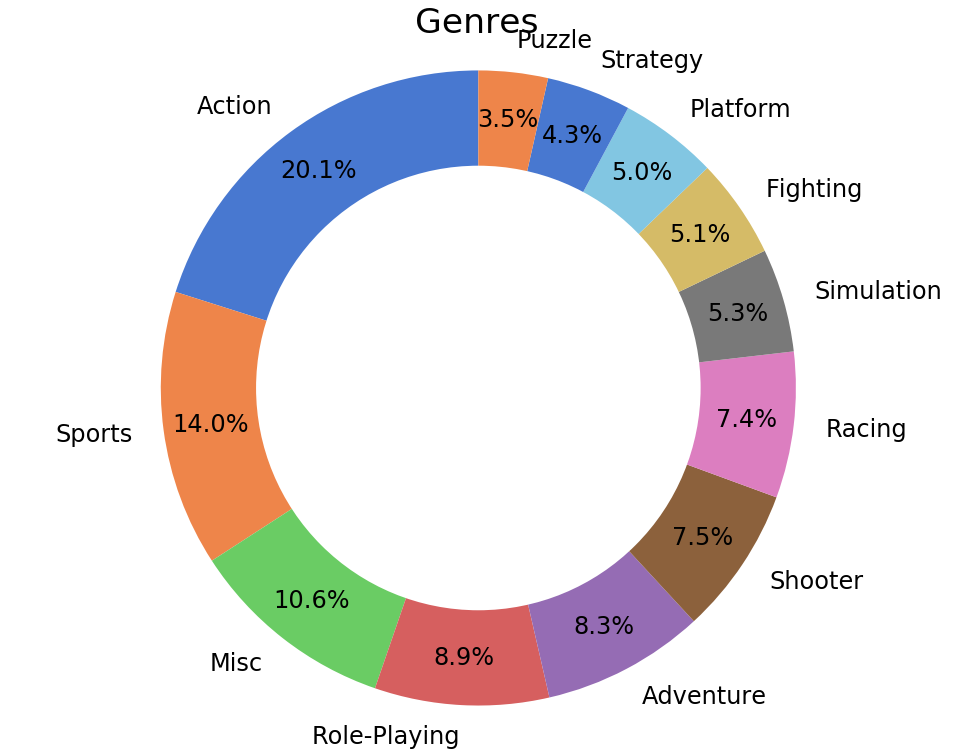

In [88]:
donut_chart(data["Genre"], palette="muted")
plt.title("Genres")
plt.axis("equal");

The distribution seems ok, even though there is a significant number of different genres.

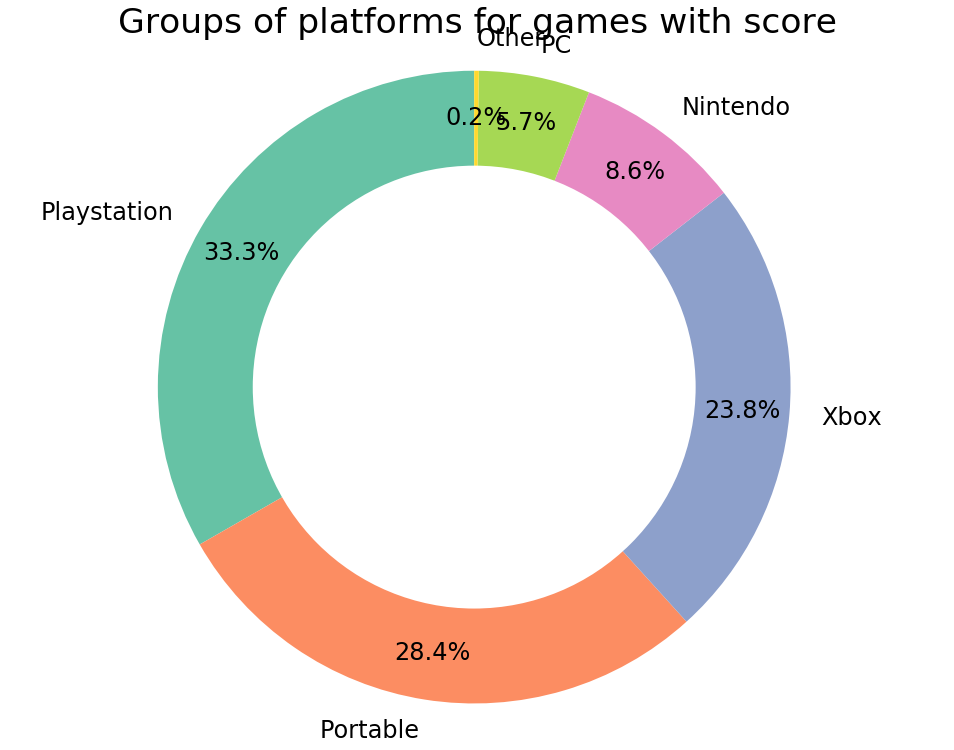

In [89]:
scored["Grouped_Platform"] = scored["Platform"].apply(lambda x: get_group_label(x, platforms))
donut_chart(scored["Grouped_Platform"])
plt.title("Groups of platforms for games with score")
plt.axis("equal");

Almost all games that have scores are for "big" platfroms: PC, PS, Xbox or portable. But there are few from the "Other" group. I was interested what these games were so I searched for them.

In [90]:
scored[scored["Grouped_Platform"]=="Other"]

,Name,Platform,Year,Genre,Publisher,NA,EU,JP,Other,Global,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,Age,Has_Score,Country,Grouped_Platform
1712,Shenmue,DC,1999,Adventure,Sega,0.52,0.24,0.38,0.04,1.18,88.0,9.0,9.4,201.0,Sega AM2,T,19,True,NA,Other
1877,NFL 2K1,DC,2000,Sports,Sega,1.02,0.05,0.00,0.02,1.09,97.0,22.0,6.0,47.0,Visual Concepts,E,18,True,NA,Other
3815,Seaman,DC,1999,Simulation,Sega,0.00,0.00,0.52,0.00,0.52,82.0,24.0,8.4,16.0,Vivarium,T,19,True,JP,Other
5350,SoulCalibur,DC,1999,Fighting,Namco Bandai Games,0.00,0.00,0.34,0.00,0.34,98.0,24.0,8.8,200.0,Namco,T,19,True,JP,Other
7231,Capcom vs. SNK,DC,2000,Fighting,Virgin Interactive,0.00,0.00,0.22,0.00,0.22,80.0,17.0,9.0,24.0,Capcom,T,18,True,JP,Other
7521,Phantasy Star Online,DC,2000,Role-Playing,Sega,0.00,0.00,0.20,0.00,0.20,89.0,21.0,9.1,33.0,Sonic Team,T,18,True,JP,Other
7643,Grandia II,DC,2000,Role-Playing,Ubisoft,0.00,0.00,0.20,0.00,0.20,90.0,17.0,8.8,57.0,Game Arts,T,18,True,JP,Other
7978,Phantasy Star Online Ver. 2,DC,2001,Role-Playing,Sega,0.00,0.00,0.19,0.00,0.19,80.0,10.0,8.9,18.0,Sonic Team,T,17,True,JP,Other
8905,Shenmue II,DC,2001,Adventure,Sega,0.00,0.00,0.15,0.00,0.15,88.0,9.0,9.4,201.0,Sega AM2,T,17,True,JP,Other
9559,Sega GT,DC,2000,Racing,Sega,0.00,0.00,0.13,0.00,0.13,84.0,25.0,7.7,11.0,TOSE,E,18,True,JP,Other


All these games are for "DC" platfom which is Sega Dreamcast, the last of Sega consoles. It was released in 1998 and was the first of sixth generation consoles,  PS2, Gamecube and Xbox. Dreamcast was actually a very good and innovative  product which recieved a lot of positive credit, but it couldn't compete with Sony or Microsoft consoles and Sega was forced to stop the production.

   In 2006 Sega started a new wave of sales of Dreamcast consoles and games, which were restored from the leftovers of first production. Following this, IGN re-launched their IGN Dreamcast section to review these games and compare them with PS3, Xbox 360 and Wii games.

Next I want to create some new features: weighted score and my own developer rating. First, I find percent of all games created by each developer, then calculate cumulative percent starting with devs with the least number of games. Finally, I divide them into 5 groups (20% each). Higher rank means more games developed.

In [91]:
scored["Weighted_Score"] = (scored["User_Score"] * 10 * scored["User_Count"] + 
                            scored["Critic_Score"] * scored["Critic_Count"]) / (scored["User_Count"] + scored["Critic_Count"])
devs = pd.DataFrame({"dev": scored["Developer"].value_counts().index,
                     "count": scored["Developer"].value_counts().values})
m_score = pd.DataFrame({"dev": scored.groupby("Developer")["Weighted_Score"].mean().index,
                        "mean_score": scored.groupby("Developer")["Weighted_Score"].mean().values})
devs = pd.merge(devs, m_score, on="dev")
devs = devs.sort_values(by="count", ascending=True)
devs["percent"] = devs["count"] / devs["count"].sum()
devs["top%"] = devs["percent"].cumsum() * 100
n_groups = 5
devs["top_group"] = (devs["top%"] * n_groups) // 100 + 1
devs["top_group"].iloc[-1] = n_groups
devs

,dev,count,mean_score,percent,top%,top_group
1179,Blueshift,1,85.692308,0.000181,0.018070,1.0
842,"Sega, Sonic Team",1,77.627451,0.000181,0.036140,1.0
843,Arcade Moon,1,50.360000,0.000181,0.054210,1.0
844,G1M2,1,66.833333,0.000181,0.072280,1.0
845,Ntreev Soft,1,73.862069,0.000181,0.090351,1.0
846,Pax Softonica,1,87.120000,0.000181,0.108421,1.0
847,PuzzleKings,1,65.090909,0.000181,0.126491,1.0
848,Enlight Software,1,33.884615,0.000181,0.144561,1.0
849,Prograph,1,57.500000,0.000181,0.162631,1.0
850,BattleGoat Studios,1,66.461538,0.000181,0.180701,1.0


A nice graph to see the realtion between developer rank and mean weighted score of developer's games.

/home/admin1/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


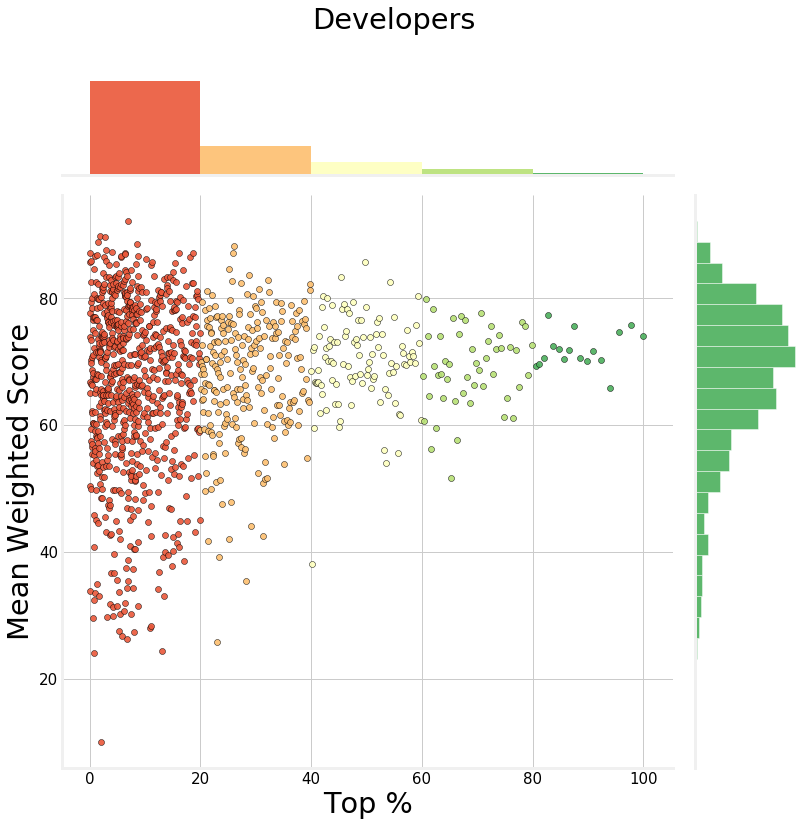

In [92]:
pal = sns.color_palette("RdYlGn", n_groups)
g = sns.JointGrid(x="top%", y="mean_score", data=devs, size=12)
legend_elements = []
for k in range(0, n_groups):
    g.ax_joint.scatter(devs[devs["top_group"]==k+1]["top%"], 
                       devs[devs["top_group"]==k+1]["mean_score"],
                       color=pal[k], alpha=.9, edgecolor="black")
    legend_elements.append(Line2D([0], [0], label=k+1, marker="o", ls="", 
                                  mfc=pal[k], mec=pal[k], alpha=.9, markersize=15))
    g.ax_marg_x.bar(np.arange(k * 100 / n_groups, (k+1) * 100 / n_groups), 
                    devs[devs["top_group"]==k+1].shape[0], 
                    width=1, align="edge", color=pal[k], alpha=.9)
g.ax_marg_y.hist(devs["mean_score"], color=pal[-1], alpha=.9,
                 orientation="horizontal", bins=25, edgecolor="white")
g.set_axis_labels("Top %", "Mean Weighted Score")
g.ax_joint.tick_params(labelsize=15)
g.ax_marg_x.grid(False)
g.ax_marg_y.grid(False)
#g.ax_joint.legend(handles=legend_elements, title="Top Group", loc=4)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Developers");

Before creating and fitting a model I have to fill in missing values. I am filling scores and counts with zeros, because there were no real zero scores or counts in the dataset, so it will indicate absence of scores.

In [93]:
data["Critic_Score"].fillna(0.0, inplace=True)
data["Critic_Count"].fillna(0.0, inplace=True)
data["User_Score"].fillna(0.0, inplace=True)
data["User_Count"].fillna(0.0, inplace=True)
data = data.join(devs.set_index("dev")["top_group"], on="Developer")
data = data.rename(columns={"top_group": "Developer_Rank"})
data["Developer_Rank"].fillna(0.0, inplace=True)
data["Rating"].fillna("None", inplace=True)

Removing outliers in User_Count column.

In [94]:
tmp, rmvd_tmp = rm_outliers(data[data["User_Count"] != 0], ["User_Count"])
data.drop(rmvd_tmp.index, axis=0, inplace=True)

Creating Weighted_Score column (earlier I did it for "scored" dataframe).

In [95]:
data["Weighted_Score"] = (data["User_Score"] * 10 * data["User_Count"] + 
                            data["Critic_Score"] * data["Critic_Count"]) / (data["User_Count"] + data["Critic_Count"])
data["Weighted_Score"].fillna(0.0, inplace=True)

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14743 entries, 1058 to 16718
Data columns (total 22 columns):
Name                14743 non-null object
Platform            14743 non-null object
Year                14743 non-null int64
Genre               14743 non-null object
Publisher           14712 non-null object
NA                  14743 non-null float64
EU                  14743 non-null float64
JP                  14743 non-null float64
Other               14743 non-null float64
Global              14743 non-null float64
Critic_Score        14743 non-null float64
Critic_Count        14743 non-null float64
User_Score          14743 non-null float64
User_Count          14743 non-null float64
Developer           8519 non-null object
Rating              14743 non-null object
Age                 14743 non-null int64
Has_Score           14743 non-null bool
Country             14743 non-null object
Grouped_Platform    14743 non-null object
Developer_Rank      14743 non-null float64
W

Now I will do the same things as I did in the basic model, except for using Ordinal encoding for categorical values instead of OneHot. I tried different kinds of encodings, and ordinal seems to work best.

In [97]:
import category_encoders as ce
# Select the numeric columns
numeric_subset = data.select_dtypes("number").drop(columns=["NA", "EU", "JP", "Other", "Year"])

# Select the categorical columns
categorical_subset = data[["Grouped_Platform", "Genre", "Rating"]]

# One hot encode
# categorical_subset = pd.get_dummies(categorical_subset)

mapping = []
for cat in categorical_subset.columns:
    tmp = scored.groupby(cat).median()["Weighted_Score"]
    mapping.append({"col": cat, "mapping": [x for x in np.argsort(tmp).items()]})
    
encoder = ce.ordinal.OrdinalEncoder()
categorical_subset = encoder.fit_transform(categorical_subset, mapping=mapping)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

# Find correlations with the score 
correlations = features.corr()["Global"].dropna().sort_values()

In [98]:
target = pd.Series(features["Global"])
features = features.drop(columns="Global")
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2,
                                                                            random_state=42)
baseline_guess = np.median(target_train)
baseline_mae = mae(target_test, baseline_guess)
print("Baseline guess for global sales is: {:.02f}".format(baseline_guess))
print("Baseline Performance on the test set: MAE = {:.04f}".format(baseline_mae))

Baseline guess for global sales is: 0.14
Baseline Performance on the test set: MAE = 0.2222


In [99]:
model = GradientBoostingRegressor(random_state = 42)

random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=20, 
                               scoring="neg_mean_absolute_error",
                               n_jobs=-1, verbose=1, 
                               return_train_score=True,
                               random_state=42)
random_cv.fit(features_train, target_train);

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   58.9s finished


In [100]:
trees_grid = {"n_estimators": [50, 100, 150, 200, 250, 300]}

model = random_cv.best_estimator_
grid_search = GridSearchCV(estimator=model, param_grid=trees_grid, cv=4, 
                           scoring="neg_mean_absolute_error", verbose=1,
                           n_jobs=-1, return_train_score=True)
grid_search.fit(features_train, target_train);

Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.1min finished


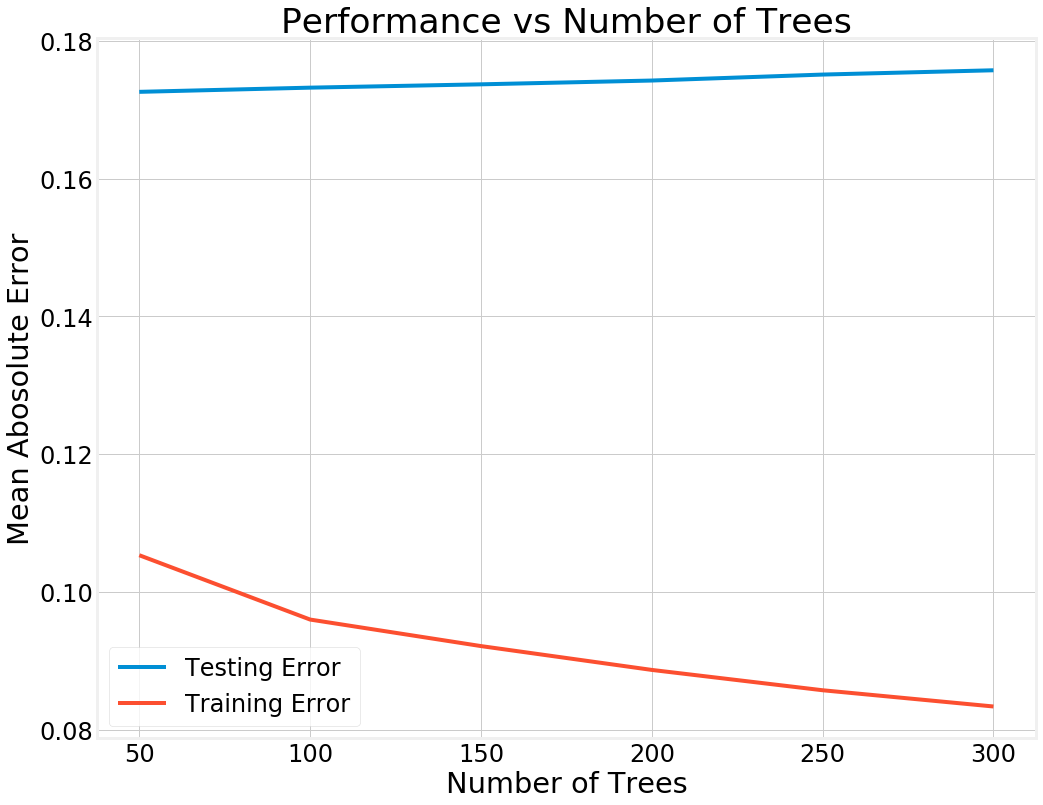

In [101]:
results = pd.DataFrame(grid_search.cv_results_)

plt.plot(results["param_n_estimators"], -1 * results["mean_test_score"], label = "Testing Error")
plt.plot(results["param_n_estimators"], -1 * results["mean_train_score"], label = "Training Error")
plt.xlabel("Number of Trees"); plt.ylabel("Mean Abosolute Error"); plt.legend();
plt.title("Performance vs Number of Trees");

In [102]:
final_model = grid_search.best_estimator_
final_pred = final_model.predict(features_test)
final_mae = mae(target_test, final_pred)
print("Final model performance on the test set: MAE = {:.04f} and Accuracy is: {}.".format(final_mae,(1-final_mae*100)))

Final model performance on the test set: MAE = 0.1752.


"Advanced" model gives better results (lower error on test set) which is a good achievement, but the model is still overfitting (graph above). There is definitely room for improvement. 

And to finish with the project, a nice group of plots summarizing the results.

/home/admin1/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


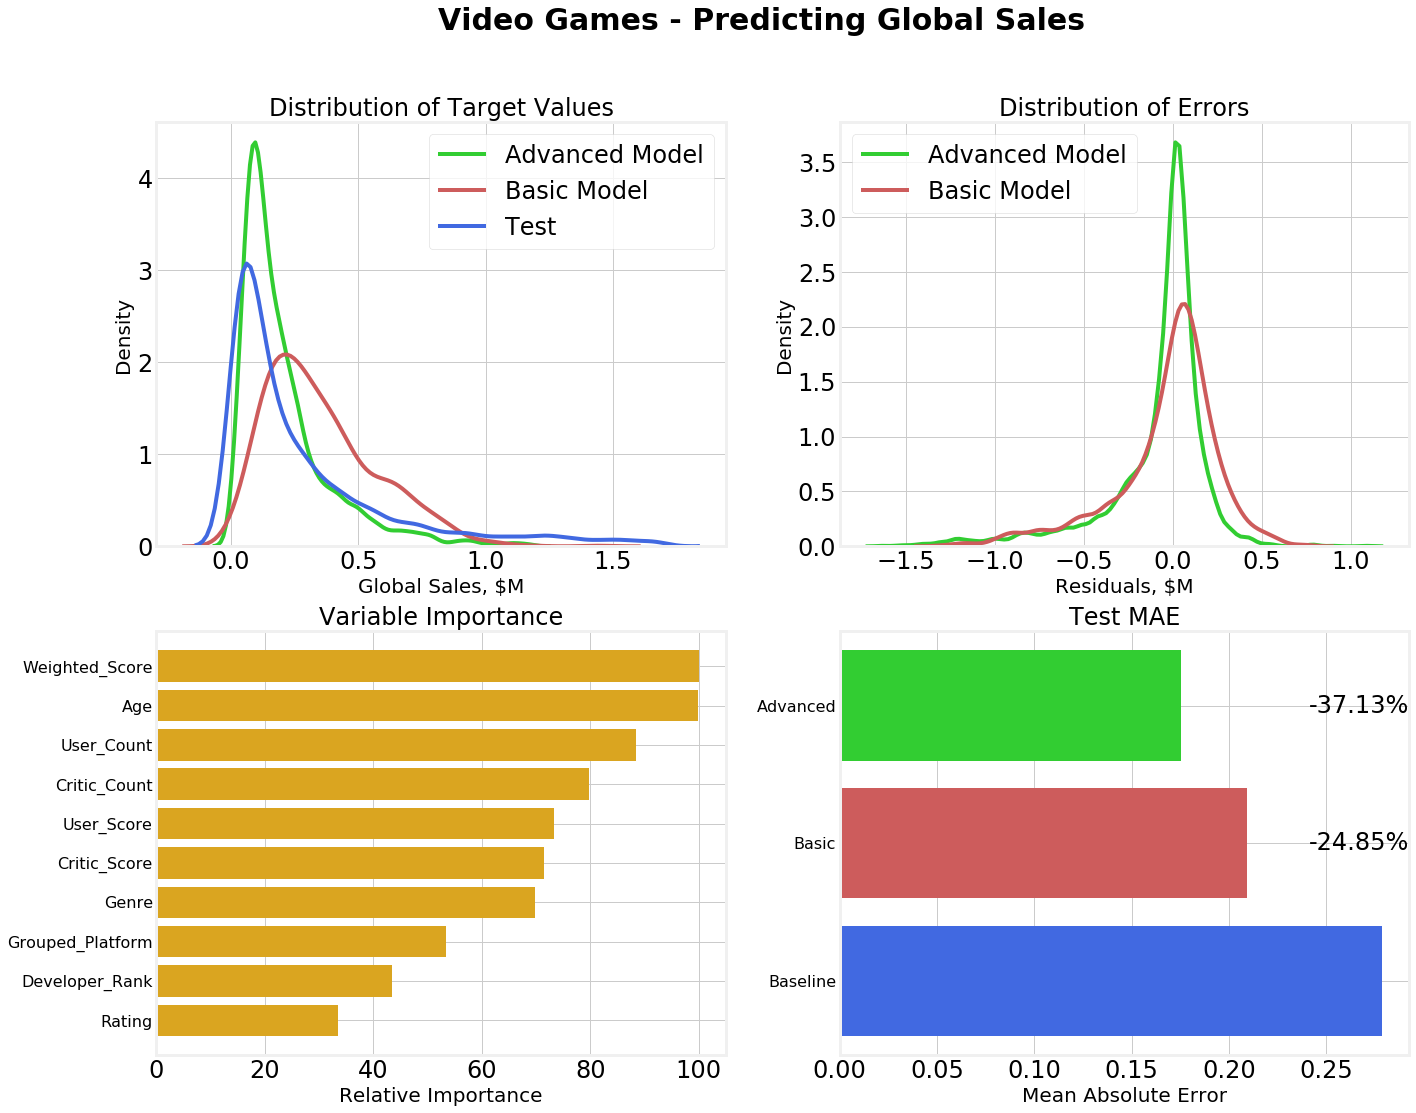

In [103]:
import matplotlib.gridspec as gridspec
figsize(20, 16)

fig = plt.figure()
gs = gridspec.GridSpec(2, 2)

plt.suptitle("Video Games - Predicting Global Sales", size=30, weight="bold");

ax = fig.add_subplot(gs[0, 0])
plt.sca(ax)
sns.kdeplot(final_pred, color="limegreen", label="Advanced Model")
sns.kdeplot(basic_final_pred, color="indianred", label="Basic Model")
sns.kdeplot(target_test, color="royalblue", label="Test")
plt.xlabel("Global Sales, $M", size=20); plt.ylabel("Density", size=20);
plt.title("Distribution of Target Values", size=24);

residuals = final_pred - target_test
ax = fig.add_subplot(gs[0, 1])
plt.sca(ax)
sns.kdeplot(residuals, color = "limegreen", label="Advanced Model")
sns.kdeplot(basic_residuals, color="indianred", label="Basic Model")
plt.xlabel("Residuals, $M", size=20);plt.ylabel("Density", size=20);
plt.title("Distribution of Errors", size=24);

feature_importance = final_model.feature_importances_
feature_names = features.columns.tolist()
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
ax = fig.add_subplot(gs[1, 0])
plt.sca(ax)
plt.barh(pos, feature_importance[sorted_idx], align='center', color="goldenrod")
plt.yticks(pos, [feature_names[x] for x in sorted_idx], size=16)
plt.xlabel('Relative Importance', size=20)
plt.title('Variable Importance', size=24);

model_comparison = pd.DataFrame({"model": ["Baseline", "Basic", "Advanced"],
                                 "mae": [basic_baseline_mae, basic_final_mae, final_mae],
                                 "diff": ["0.00%", "-{:.2f}%".format((1 - basic_final_mae / basic_baseline_mae) * 100), "-{:.2f}%".format((1 - final_mae / basic_baseline_mae) * 100)],
                                 "color": ["royalblue", "indianred", "limegreen"]})
model_comparison.sort_values("mae", ascending=False)
pos = np.arange(3) + .5
ax = fig.add_subplot(gs[1, 1])
plt.sca(ax)
plt.barh(pos, model_comparison["mae"], align="center", color=model_comparison["color"])
for i in [1, 2]:
    plt.text(plt.xlim()[1], pos[i], model_comparison["diff"][i], 
             verticalalignment="center", horizontalalignment="right")
plt.yticks(pos, model_comparison["model"], size=16); plt.xlabel("Mean Absolute Error", size=20);
plt.title("Test MAE", size=24);